In [2]:
!pip install lxml
!pip install bs4
from bs4 import BeautifulSoup

import re
import xml.sax.saxutils as saxutils

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import pandas as pd
import numpy as np

# from keras.models import Sequential
# from keras.layers.embeddings import Embedding
# from keras.layers.recurrent import GRU
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.layers import Dense, Dropout
# from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
import matplotlib.ticker as mtick

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
#from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

import itertools

# use GPU
# import tensorflow as tf
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_visible_devices(physical_devices[2], 'GPU')

You are using pip version 9.0.1, however version 22.0.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 22.0.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
[nltk_data] Downloading package stopwords to /Users/vasileios-
[nltk_data]     mariosgkortsas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/vasileios-
[nltk_data]     mariosgkortsas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/Users/vasileios-mariosgkortsas/anaconda3/envs/dog-project/lib/python3.5/site-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


In [3]:
import sys
print(sys.executable)

/Users/vasileios-mariosgkortsas/anaconda3/envs/dog-project/bin/python


# Functions that help to extract classes

In [4]:
ver='GRU_1_layer_TFIDF'

def remove_tags(text):
    return re.sub('<[^<]+>', '', text).strip() # reference: https://stackoverflow.com/questions/12823568/python-strip-xml-tags-from-document

folder = './reuters21578/'

# files that have the classes
# we save the files in a dictionary where key is the category (i.e. topics, places, people, organizations, exchanges)
# each categoty has different classes (labels)
classes_files = {
    'Topics_': 'all-topics-strings.lc.txt',
    'Places_': 'all-places-strings.lc.txt',
    'People_': 'all-people-strings.lc.txt',
    'Organizations_': 'all-orgs-strings.lc.txt',
    'Exchanges_': 'all-exchanges-strings.lc.txt'
}


# we save the categories and the classes and initiate (i.e 0) a counter, 
# which measures the number of documents thet each class appears. 
# We will use that for our dataframe
classes = []

for key in classes_files.keys():
    with open(folder + classes_files[key], 'r') as file:
        for class_ in file.readlines():
            classes.append([key[:-1], key.lower() + class_.strip().lower(), 0])  # strip() to remove the leading and trailing characters
  
# create a dataframe
classes_df = pd.DataFrame(data=classes, columns=['category', 'class','number_of_documents'])

# for each document we read the classes 
def create_doc_classes(doc_):
    
    topics = doc_.topics.contents
    places = doc_.places.contents
    people = doc_.people.contents
    orgs = doc_.orgs.contents
    exchanges = doc_.exchanges.contents
        
    doc_classes=[]
    for topic in topics:
        doc_classes.append('topics_' + remove_tags(str(topic)))
                
    for place in places:
        doc_classes.append('places_' + remove_tags(str(place)))
                
    for person in people:
        doc_classes.append('people_' + remove_tags(str(person)))
                
    for org in orgs:
        doc_classes.append('organizations_' + remove_tags(str(org)))
                
    for exchange in exchanges:
        doc_classes.append('exchanges_' + remove_tags(str(exchange)))
                
    return doc_classes
   
    
# populate the dataframe, i.e. count in how many documents each class appears
def populate_df(classes_):
    for class_ in classes_:
        idx = classes_df[classes_df['class'] == class_].index[0]
        count = classes_df._get_value(idx, 'number_of_documents')
        classes_df._set_value(idx, 'number_of_documents', count+1)
        

# since each document can belong to multiple classes, we have a multi-class, multi-label classification problem, 
# so we need to do multi-hot encoding
def multi_hot_encoding(classes_, target_classes):
    multi_hot_vector = np.zeros(len(target_classes)).astype(np.float32)
    
    for i in range(len(target_classes)):
        # we set as 1 the element of the vector which corresponds to one of the document classes
        if target_classes[i] in classes_:
            multi_hot_vector[i] = 1.0
    
    return multi_hot_vector

# Process the documents to extract features and classes

In [5]:
# top 20 classes
selected_classes = ['places_usa', 'topics_earn', 'topics_acq', 'places_uk', 'places_japan', 'places_canada', 'topics_money-fx',
 'topics_crude', 'topics_grain', 'places_west-germany', 'topics_trade', 'topics_interest',
 'places_france', 'organizations_ec', 'places_brazil', 'topics_wheat', 'topics_ship', 'places_australia',
 'topics_corn', 'places_china']

# top 40 classes

# selected_classes = ['places_usa', 'topics_earn', 'topics_acq', 'places_uk', 'places_japan', 'places_canada', 'topics_money-fx',
#  'topics_crude', 'topics_grain', 'places_west-germany', 'topics_trade', 'topics_interest',
#  'places_france', 'organizations_ec', 'places_brazil', 'topics_wheat', 'topics_ship', 'places_australia',
#  'topics_corn', 'places_china', 'topics_dlr', 'places_ussr', 'places_switzerland', 'places_belgium', 'places_netherlands', 
# 'topics_oilseed', 'topics_money-supply', 'topics_sugar', 'places_iran', 'places_italy', 'people_james-baker', 'people_reagan',
# 'topics_gnp', 'topics_coffee', 'places_hong-kong', 'topics_veg-oil', 'places_philippines', 'topics_gold', 
# 'topics_nat-gas', 'places_taiwan']

doc_X = []
doc_Y = []

# read the SGML files
number_of_sgml_files = 22
for i in range(number_of_sgml_files):
    file_name = 'reut2-{}.sgm'.format(str(i).zfill(3))
    print('file: %s' % file_name)
    
    with open(folder + file_name, 'rb') as file:
        content = BeautifulSoup(file.read().lower(), "lxml")
        
        for doc in content('reuters'):
            
            # Step 1: Extract the text from the document
            doc_body=str(doc('text'))
            # Step 2: Remove tags
            doc_body=remove_tags(str(doc('text')[0]))
            # Step 3: remove 'reuter'
            doc_body=doc_body.replace('reuter', '')
            # Step 4: Remove the next line character
            doc_body=doc_body.replace('\n','')
            # Step 5: remove the end of text character, i.e. &#3
            doc_body = doc_body.replace('&#3','')
            # Step 6: remove escape characters like &lt, &gt
            doc_body = saxutils.unescape(doc_body)
        
            doc_X.append(doc_body)

            doc_classes=create_doc_classes(doc)
            populate_df(doc_classes)
            doc_Y.append(multi_hot_encoding(doc_classes, selected_classes))

file: reut2-000.sgm
file: reut2-001.sgm
file: reut2-002.sgm
file: reut2-003.sgm
file: reut2-004.sgm
file: reut2-005.sgm
file: reut2-006.sgm
file: reut2-007.sgm
file: reut2-008.sgm
file: reut2-009.sgm
file: reut2-010.sgm
file: reut2-011.sgm
file: reut2-012.sgm
file: reut2-013.sgm
file: reut2-014.sgm
file: reut2-015.sgm
file: reut2-016.sgm
file: reut2-017.sgm
file: reut2-018.sgm
file: reut2-019.sgm
file: reut2-020.sgm
file: reut2-021.sgm


# Study and choose the output classes

## Distribution of the number of documents per class

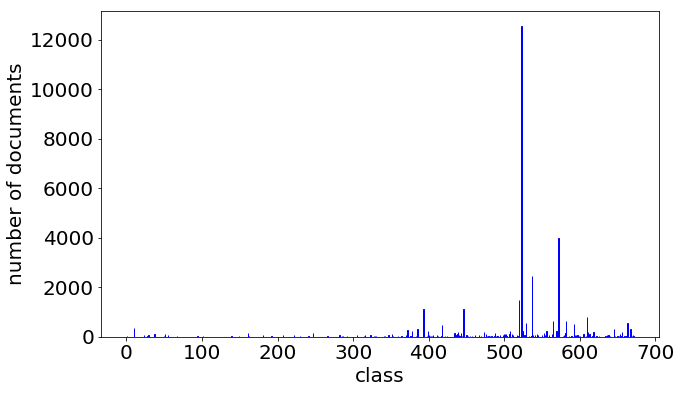

In [6]:
all_classes=range(0,len(classes_df['number_of_documents']))  # 672 classes in total
values = list(classes_df['number_of_documents'])

plt.figure(figsize=(10, 6))
plt.bar(list(all_classes), values, color ='maroon', width = 0.4,ec='blue')
plt.xlabel('class',fontsize=20)
plt.ylabel('number of documents',fontsize=20)
plt.show()

## Since the classes are imbalanced, we classify the documents to the ones that appear most of the time
## Top 20 classes appear in 72% of the documents

In [7]:
num_classes=20
classes_df_sorted=classes_df.sort_values(by='number_of_documents', ascending=False)
classes_df_sorted.head(num_classes)

,category,class,number_of_documents
523,Places,places_usa,12542
572,Topics,topics_earn,3987
537,Topics,topics_acq,2448
520,Places,places_uk,1489
446,Places,places_japan,1138
393,Places,places_canada,1104
610,Topics,topics_money-fx,801
565,Topics,topics_crude,634
582,Topics,topics_grain,628
529,Places,places_west-germany,567


In [7]:
top_classes=range(0,len(classes_df_sorted['number_of_documents'][0:num_classes])) 
top_classes_names=list(classes_df_sorted['class'])[0:num_classes]

values = list(classes_df_sorted['number_of_documents'][0:num_classes])

fig,ax=plt.subplots(figsize=(20, 6))
ax.bar(list(top_classes), values, color ='maroon', width = 0.4,ec='blue')
ax.set_ylabel('number of documents')
ax.set_xlabel('class')
#ax.set_xticks(list(top_classes), top_classes_names)
#ax.set_xticklabels(top_classes_names,rotation=90)
plt.xticks(list(top_classes), top_classes_names, rotation=90)

ax2=ax.twinx()
ax2.plot(list(top_classes), np.cumsum(classes_df_sorted['number_of_documents'][0:num_classes])/np.sum(classes_df_sorted['number_of_documents']),'r-o') # I did not multiply by 100 because of the last command
ax2.set_ylabel('cumulative')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
ax2.set_ylim([0,1])
#ax2.set_xticklabels(top_classes_names,rotation=90)

AttributeError: module 'matplotlib.ticker' has no attribute 'PercentFormatter'

# Process the input features

## Clean the features by keeping the alphanumeric values, doing lemmatization and removing the stopwords

In [8]:
keep_alphanumeric_chars = re.compile("[^A-Za-z0-9 ]+")
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean(r):
    r = r.lower().replace("<br />", " ")
    r = re.sub(keep_alphanumeric_chars, "", r.lower())
    
    words = word_tokenize(r)
    clean_sequence = []
    for word in words:
        # lematize
        word = lemmatizer.lemmatize(word)
        
        # remove stop words
        if word not in stop_words:
            clean_sequence.append(word)
    return " ".join(clean_sequence)


### Features and classes for a specific document

In [9]:
mmm=210
print(clean(doc_X[mmm]))
print()
print(doc_Y[mmm])

houston oil ho reserve study completed houston feb 26 houston oil trust said independentpetroleum engineer completed annual study estimatesthe trust future net revenue total proved reserve at88 mln dlrs discounted present value reserve at64 mln dlrs based estimate trust said may moneyavailable cash distribution unitholders theremainder year said estimate reflect decrease 44 pct innet reserve revenue 39 pct discounted present valuecompared study made 1985

[1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [10]:
X = []
for i, doc in enumerate(doc_X):
    X.append(clean(doc))
    
Y = np.array(doc_Y)

## TF-IDF vectorizer

In [11]:
vectorizer = TfidfVectorizer()
X_tdidf = vectorizer.fit_transform(X)

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X_tdidf, Y, test_size=0.2)

In [13]:
def grid_search_fun(classifier, parameters):
    clf = GridSearchCV(estimator = classifier,
                               param_grid = parameters,
                               scoring = 'f1_micro',
                               verbose=0,
                               cv=5)
    clf.fit(X_train, Y_train)
    print ("best f1-weighted score: {0}".format(clf.best_score_))
    print ("best parameters: {0}".format(clf.best_params_))
    print()
    print("Grid scores on validation set:")
    print()
    
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.6f (+/-%0.06f) for %r" % (mean, std * 2, params))
    print()
    print("Detailed classification report:")
    Y_pred = clf.predict(X_test)
    print(classification_report(Y_test, Y_pred, target_names=selected_classes))


In [16]:
def plot_confusion_matrix_(cm, classes,
                          normalize=None,
                          title=None,
                          cmap=plt.cm.Reds):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=14)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=14)
    plt.yticks(tick_marks, classes,fontsize=14)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')
                   
    fmt = '.2f' if normalize else 'd'       
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha="center", va="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    #plt.ylabel('True label')
    #plt.xlabel('Predicted label')
    
    
def reshape_confusion_matrix(cf):
    res_cf=np.zeros((2,2),dtype=int)
    res_cf[0][0]=cf[1][1]
    res_cf[0][1]=cf[1][0]
    res_cf[1][0]=cf[0][1]
    res_cf[1][1]=cf[0][0]
    
    return res_cf


def create_conf_mat_dict(Y_pred, Y_test):

    conf_mat_dict={}

    for label_col in range(len(selected_classes)):
        y_true_label = Y_test[:, label_col]
        y_pred_label = Y_pred[:, label_col]
        conf_mat_dict[selected_classes[label_col]] = confusion_matrix(y_true=y_true_label, y_pred=y_pred_label)
        
    return conf_mat_dict

In [17]:
def plot_confusion_matrices(Y_pred, Y_test, normalize=None):

    plt.figure(figsize=(20, 10))

    conf_mat_dict=create_conf_mat_dict(Y_pred, Y_test)

    for kkk in range(len(selected_classes)):
        cf=conf_mat_dict[selected_classes[kkk]]
        conf_mat=reshape_confusion_matrix(cf)
        plt.subplot(4,5,kkk+1)
        plot_confusion_matrix_(conf_mat,classes=['True', 'False'], normalize=normalize, title=selected_classes[kkk])
        plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.5, 
                    wspace=0.3, 
                    hspace=0.4)
    
        if kkk>=15 and kkk<=19:
            plt.xlabel('predicted',fontsize=20)
        
        if kkk%5==0:
            plt.ylabel('actual',fontsize=20)
        
    plt.show()

# Logistic regression

In [16]:
parameters = [{'estimator__penalty' : ['l1','l2'], 
               'estimator__C': [5, 15, 25, 35, 45, 50]}]
classifier = OneVsRestClassifier(LogisticRegression())
grid_search_fun(classifier,parameters)




best f1-weighted score: 0.8819321402576719
best parameters: {'estimator__penalty': 'l1', 'estimator__C': 35}

Grid scores on validation set:

0.881585 (+/-0.003883) for {'estimator__penalty': 'l1', 'estimator__C': 5}
0.857983 (+/-0.005342) for {'estimator__penalty': 'l2', 'estimator__C': 5}
0.881761 (+/-0.002207) for {'estimator__penalty': 'l1', 'estimator__C': 15}
0.870300 (+/-0.004643) for {'estimator__penalty': 'l2', 'estimator__C': 15}
0.881583 (+/-0.003023) for {'estimator__penalty': 'l1', 'estimator__C': 25}
0.873379 (+/-0.006301) for {'estimator__penalty': 'l2', 'estimator__C': 25}
0.881932 (+/-0.003671) for {'estimator__penalty': 'l1', 'estimator__C': 35}
0.875091 (+/-0.006812) for {'estimator__penalty': 'l2', 'estimator__C': 35}
0.881518 (+/-0.003100) for {'estimator__penalty': 'l1', 'estimator__C': 45}
0.875860 (+/-0.006605) for {'estimator__penalty': 'l2', 'estimator__C': 45}
0.881715 (+/-0.002954) for {'estimator__penalty': 'l1', 'estimator__C': 50}
0.876136 (+/-0.007129) f

In [19]:
import time

start_time= time.time()

classifier_LR = OneVsRestClassifier(LogisticRegression(penalty='l1',C=35))
classifier_LR.fit(X_train, Y_train)
 
Y_pred_LR = classifier_LR.predict(X_test)

precision_LR = precision_score(Y_test, Y_pred_LR,
average='micro')
recall_LR = recall_score(Y_test, Y_pred_LR,
average='micro')
f1_LR = f1_score(Y_test, Y_pred_LR, average='micro')
 
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision_LR, recall_LR, f1_LR))

time.time()-start_time

Precision: 0.9042, Recall: 0.8689, F1-measure: 0.8862


20.59238886833191

In [14]:
print(classification_report(Y_test, Y_pred_LR, target_names=selected_classes))

                     precision    recall  f1-score   support

         places_usa       0.94      0.94      0.94      2470
        topics_earn       0.94      0.89      0.91       812
         topics_acq       0.84      0.80      0.82       489
          places_uk       0.88      0.78      0.83       317
       places_japan       0.93      0.82      0.87       228
      places_canada       0.87      0.83      0.85       231
    topics_money-fx       0.77      0.74      0.76       137
       topics_crude       0.90      0.86      0.88       128
       topics_grain       0.91      0.84      0.87       128
places_west-germany       0.86      0.71      0.78       115
       topics_trade       0.76      0.68      0.72       111
    topics_interest       0.78      0.70      0.74        96
      places_france       0.77      0.70      0.74        91
   organizations_ec       0.87      0.78      0.82        74
      places_brazil       0.87      0.76      0.81        62
       topics_wheat    

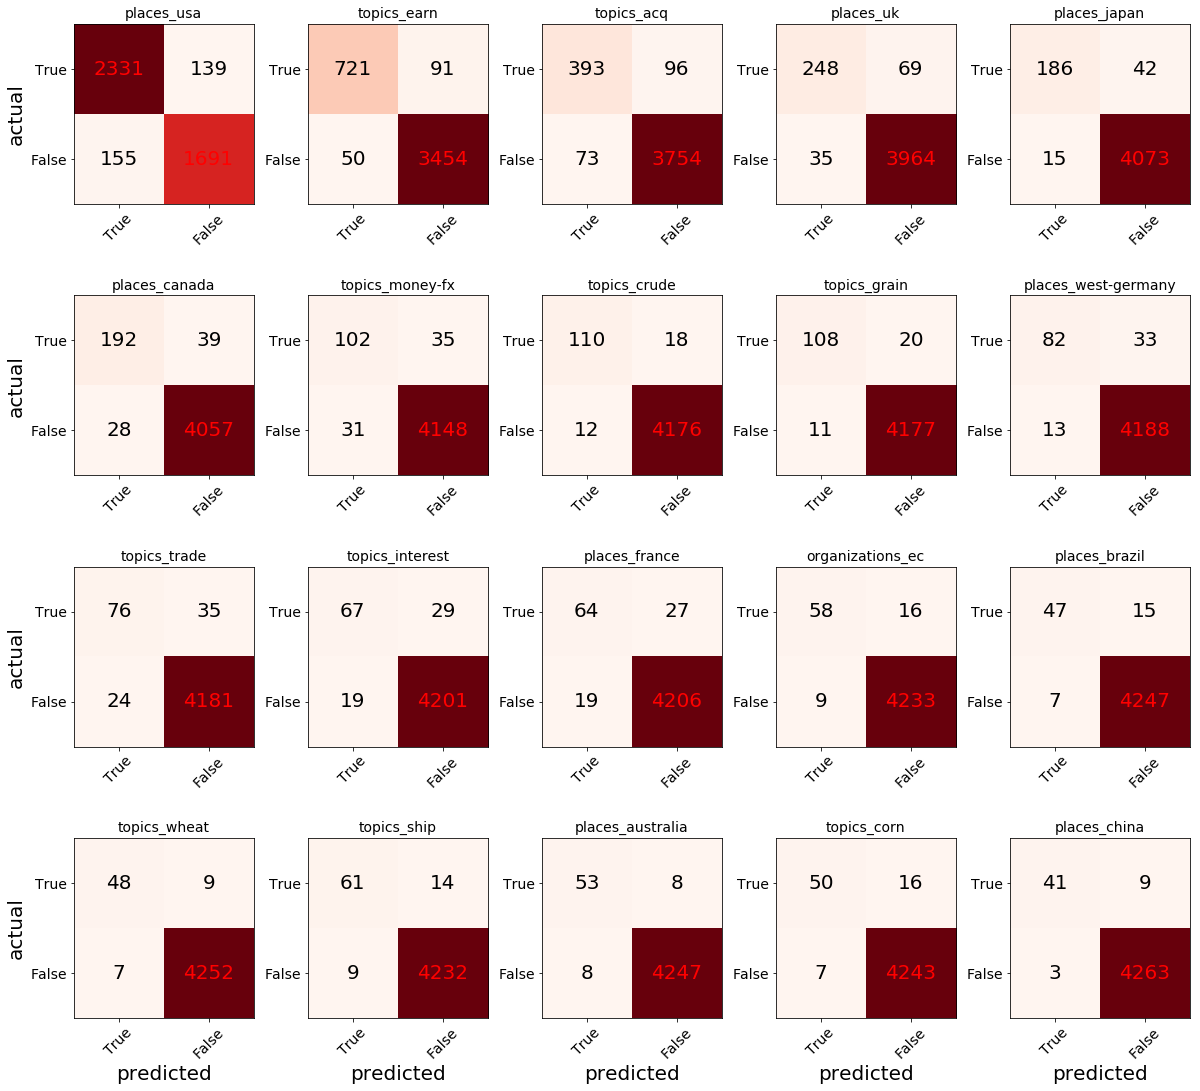

In [18]:
plot_confusion_matrices(Y_pred_LR, Y_test, normalize=False)